# sprint 深層学習スクラッチ 畳み込みニューラルネットワーク２

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## データセットの用意
引き続きMNISTデータセットを使用します。2次元畳み込み層へは、28×28の状態で入力します。

In [2]:
# データロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# channel次元の追加(NCHW)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

#分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# one_hot化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.fit_transform(y_val[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

# 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

In [3]:
class Conv2D:
    """
    チャネル複数、ストライド複数、パディング複数、バッチサイズ複数
    
    get_NH_out(NH_in, FH, PH, SH)を使用して出力サイズを求める
    
    N_in : (NH_in, NW_in)
    Filter : (C_out, C_in, FH, FW)
    Strides : (SH, SW)
    Padding : (PH, PW)
    Activation : 活性化層の種類
    Initializer : 初期化方法の種類
    Optimizer : 最適化手法の種類
    """
    def __init__(self, N_in, Filter, Strides, Padding, Initializer, Optimizer):
        # conv初期値
        self.C_in = Filter[1]
        self.C_out = Filter[0]
        self.FH = Filter[2]
        self.FW = Filter[3]
        self.SH = Strides[0]
        self.SW = Strides[1]
        self.PH = Padding[0]
        self.PW = Padding[1]
        self.NH_in = N_in[0]
        self.NW_in = N_in[1]
        # 割り切れない場合、強制終了になるよう関数get_outsizeを設定
        self.NH_out = get_NH_out(self.NH_in, self.FH, self.PH, self.SH)
        self.NW_out = get_NW_out(self.NW_in, self.FW, self.PW, self.SW)
        self.N = None
        # 最適化
        self.optimizer = Optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = Initializer
        self.W = self.initializer.W(self.C_out, self.C_in, self.FH, self.FW)    # (出力チャンネル数、入力チャンネル数、フィルタサイズ)
        self.B = self.initializer.B(self.C_out)    # (出力チャンネル数)
        # 初期値
        self.Z = None
        #  AdaGrad用の変数
        self.H_B = 0
        self.H_W = 0
        
    
    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.N = Z.shape[0]
        # backward用に確保
        self.Z = Z
        # forward計算        
        # 出力の初期設定
        A = np.zeros([self.N, self.C_out, self.NH_out, self.NW_out])
        # パディングに合わせてxを変換
        self.Z = np.pad(self.Z, [(0,0), (0, 0), (self.PH, self.PH), (self.PW, self.PW)], 'constant')
        # tensordotによるテンソル積(チャネルファーストに合わせたインデックス)
        dim = [i for i in range(self.Z.ndim)]   
        # バッチに対してブロードキャスト
        # ストライドに合わせる
        for r in range(self.NH_out):
            # H方向のステップ
            r_step = r*self.SH
            for c in range(self.NW_out):
                # W方向のステップ
                c_step = c*self.SW
                A[:, :, r, c] = np.tensordot(self.Z[:, :, r_step:r_step+self.FH, c_step:c_step+self.FW],
                                                      self.W, axes=(dim[1:], dim[1:])) + self.B
        return A
    
    
    def backward(self, dA):
        # backwardの計算
        # dB
        dB = dA.sum(axis=(0, -2, -1))
        # dW
        # バッチに対してブロードキャスト(dAのチャネル次元を残すように設計)
        dW = np.zeros_like(self.W)
        for channel in range(self.C_out):
            for r in range(self.NH_out):
                # H方向のステップ
                r_step = r*self.SH
                for c in range(self.NW_out):
                    # W方向のステップ
                    c_step = c*self.SW
                    dW[channel, :, :, :] += (self.Z[:, :, r_step:r_step+self.FH, c_step:c_step+self.FW]
                                                     *dA[:, channel:channel+1, r:r+1, c:c+1]).sum(axis=0)
        # dZ
        # バッチに対してブロードキャスト
        # ストライドに合わせる
        dZ = np.zeros_like(self.Z)
        for r in range(self.NH_out):
            # H方向の「０」の数
            r_start = r*self.SH
            r_end = (self.NH_out-1-r)*self.SH
            for c in range(self.NW_out):
                # W方向の「０」の数
                c_start = c*self.SW
                c_end = (self.NW_out-1-c)*self.SW
                dZ[:, :, :, :] += (np.pad(self.W, [(0,0), (0, 0), (r_start, r_end), (c_start, c_end)], 'constant')
                                     *dA[:, :, r, c].reshape(self.N, -1, 1, 1, 1)).sum(axis=1)
        # パディングの分を削除
        if self.PH>0:
            dZ = dZ[:, :, self.PH:-self.PH, :]
        if self.PW>0:
            dZ = dZ[:, :, :, self.PW:-self.PW]
        
        #  AdaGrad用の計算
        self.H_B += (dB/self.N)**2
        self.H_W += (dW/self.N)**2
        # 更新(AdaGrad用に引数を設定)
        self.B, self.W = self.optimizer.update(self.B, self.W, dB, dW, self.H_B, self.H_W, self.N)

        return dZ

# 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

In [4]:
def get_NH_out(NH_in, FH, PH, SH):
    # NH_out
    NH_out = (NH_in + 2*PH - FH)/SH + 1
    if NH_out!=int(NH_out):
        # 割り切れない場合、強制終了
        print("出力サイズが割り切れません。パディングとストライドを再設定して下さい。")
        return
    return int(NH_out)

In [5]:
def get_NW_out(NW_in, FW, PW, SW):
    # NW_out
    NW_out = (NW_in + 2*PW - FW)/SW + 1
    if NW_out!=int(NW_out):
        # 割り切れない場合、強制終了
        print("出力サイズが割り切れません。パディングとストライドを再設定して下さい。")
        return
    return int(NW_out)

# 問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、数式で表すとフォワードプロパゲーションは以下のようになります。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス (p,q) を保持しておく必要があります。フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には0を入れるためです。

In [28]:
class Max_pool:
    """
    get_NH_out(NH_in, FH, PH, SH)を使用して出力サイズを求める
    
    N_in : (NH_in, NW_in)
    Pool_size : (C_out, C_in, FH, FW)
    Strides : (SH, SW)
    Padding : (PH, PW)
    """
    def __init__(self, N_in, Pool_size, Strides, Padding):
        self.C_in = Pool_size[1]
        self.C_out = Pool_size[0]
        self.FH = Pool_size[2]
        self.FW = Pool_size[3]
        self.SH = Strides[0]
        self.SW = Strides[1]
        self.PH = Padding[0]
        self.PW = Padding[1]
        self.NH_in = N_in[0]
        self.NW_in = N_in[1]
        # 割り切れない場合、強制終了になるよう関数get_outsizeを設定
        self.NH_out = get_NH_out(self.NH_in, self.FH, self.PH, self.SH)
        self.NW_out = get_NW_out(self.NW_in, self.FW, self.PW, self.SW)
        self.N = None
        self.A_zeros = None        
        
    def forward(self, Z):
        self.N = Z.shape[0]
        A = np.zeros([self.N, self.C_out, self.NH_out, self.NW_out])
        # backward用のゼロアレイ
        self.A_zeros = np.zeros_like(Z)
        for n in range(self.N):
            for channel in range(self.C_out):
                for r in range(self.NH_out):
                    # H方向のステップ
                    r_step = r*self.SH
                    for c in range(self.NW_out):
                        # W方向のステップ
                        c_step = c*self.SW
                        # プーリング
                        max_value = np.max(Z[n, channel, r_step:r_step+self.FH, c_step:c_step+self.FW])
                        A[n, channel, r, c] = max_value
                        # backward用ゼロアレイのプーリング場所のみ「１」にする
                        # インデックス取得(ただし、得られるインデックスは先頭から数えた番号)
                        max_index = np.argmax(Z[n, channel, r_step:r_step+self.FH, c_step:c_step+self.FW])
                        # 得たインデックスを２次元インデックスへ変換
                        r_index = max_index//self.FH
                        c_index = max_index%self.FW
                        # インデックス位置の値を「１」に変換
                        self.A_zeros[n, channel, r_step:r_step+self.FH, c_step:c_step+self.FW][r_index, c_index] = 1
        return A
    
    def backward(self, dA):
        # プーリングした場所以外を「０」にする
        dA = dA.repeat(self.SH, axis=-2).repeat(self.SW, axis=-1)
        dZ = dA*self.A_zeros
        return dZ

# 【問題4】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。


範囲内の最大値ではなく、平均値を出力とするプーリング層です。


画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [7]:
class Mean_pool:
    """
    get_NH_out(NH_in, FH, PH, SH)を使用して出力サイズを求める
    
    N_in : (NH_in, NW_in)
    Pool_size : (C_out, C_in, FH, FW)
    Strides : (SH, SW)
    Padding : (PH, PW)
    """
    def __init__(self, N_in, Pool_size, Strides, Padding):
        self.C_in = Pool_size[1]
        self.C_out = Pool_size[0]
        self.FH = Pool_size[2]
        self.FW = Pool_size[3]
        self.SH = Strides[0]
        self.SW = Strides[1]
        self.PH = Padding[0]
        self.PW = Padding[1]
        self.NH_in = N_in[0]
        self.NW_in = N_in[1]
        # 割り切れない場合、強制終了になるよう関数get_outsizeを設定
        self.NH_out = get_NH_out(self.NH_in, self.FH, self.PH, self.SH)
        self.NW_out = get_NW_out(self.NW_in, self.FW, self.PW, self.SW)
        self.N = None
        self.A_zeros = None        
        
    def forward(self, Z):
        self.N = Z.shape[0]
        A = np.zeros([self.N, self.C_out, self.NH_out, self.NW_out])
        for n in range(self.N):
            for channel in range(self.C_out):
                for r in range(self.NH_out):
                    # H方向のステップ
                    r_step = r*self.SH
                    for c in range(self.NW_out):
                        # W方向のステップ
                        c_step = c*self.SW
                        # プーリング
                        mean_value = np.mean(Z[n, channel, r_step:r_step+self.FH, c_step:c_step+self.FW])
                        A[n, channel, r, c] = mean_value
        return A
    
    def backward(self, dA):
        # プーリングの分だけ繰り返す
        dZ = dA.repeat(self.SH, axis=-2).repeat(self.SW, axis=-1)
        return dZ

# 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。


フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。


この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [8]:
class Flatten:
    def __init(self):
        self.C_in = None
        self.NH_in = None
        self.NW_in = None
        self.Nodes_out = None
        self.N = None
        
    def forward(self, Z):
        self.C_in = Z.shape[1]
        self.NH_in = Z.shape[2]
        self.NW_in = Z.shape[3]
        self.N = Z.shape[0]
        
        A = Z.reshape(self.N, -1)
        self.Nodes_out = A.shape[1]
        return A
    
    def backward(self, dA):
        return dA.reshape(self.N, self.C_in, self.NH_in, self.NW_in)

# 【問題6】学習と推定
作成したConv2dを使用してMNISTを学習・推定し、Accuracyを計算してください。


精度は低くともまずは動くことを目指してください。

In [9]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
        
    def __len__(self):
        return self._stop
    
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    
    def __iter__(self):
        self._counter = 0
        return self
    
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [10]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    DNNスクラッチ
    Parameters
    ----------
    epoch_count : int
      エポック回数
    Layer_act : list
      layerとact名
    train_loss : list
      trainのエポック毎のcross_entropyを格納するリスト(エポック毎の平均値)
    val_loss : list
      valのエポック毎のcross_entropyを格納するリスト(全データ分を計算)
    """    
    def __init__(self, Layer_act, epoch_count):
        self.Layer_act = Layer_act
        self.epoch_count = epoch_count
        self.train_loss = []
        self.val_loss = []
        
    def fit(self, X, y, X_val=None, y_val=None):            
        # ミニバッチのインスタンス
        get_mini_batch = GetMiniBatch(X, y, batch_size=20)
        
        # エポック回数繰り返し
        for epoch in range(self.epoch_count):
            # イテレーション回数の初期化
            iter_count = 1
            # イテレーション毎のloss(cross_entropy)記録用array初期化
            train_loss = np.zeros(len(get_mini_batch))
            # イテレーション回数繰り返し
            for mini_X, mini_y in get_mini_batch:
                # 回数の表示
                if iter_count%2400 == 0:
                    print("エポック{}".format(epoch+1))
                    print("{}回目の学習".format(iter_count))
                    
                # 層の数だけforward
                # 処理回数の初期化
                num = 0
                # backward用の逆向きリスト
                re_Layer_act = []
                for layer_act in self.Layer_act:
                    if num==0:
                        Z_A = mini_X
                    Z_A = layer_act.forward(Z_A)
                    num += 1
                    # 逆向きリストを作成
                    re_Layer_act.insert(0, layer_act)
                  
                # 層の数だけbackward(降順)
                # 処理回数の初期化   
                num = 0
                for layer_act in re_Layer_act:
                    if num==0:
                        # 交差エントロピー誤差とソフトマックスを合わせている
                        dZ_A, train_L = layer_act.backward(mini_y)
                    else:
                        dZ_A = layer_act.backward(dZ_A)
                    num += 1
                # イテレーション毎のloss(cross_entropy)記録
                train_loss[iter_count-1] = train_L
                # イテレーション回数のカウント
                iter_count += 1
             
            # valのlossを計算
            # valのforward
            num = 0
            for layer_act in self.Layer_act:
                if num==0:
                    Z_A = X_val
                Z_A = layer_act.forward(Z_A)
                num += 1
            # valのcross_entropy計算
            dZ_A, val_L = self.Layer_act[-1].backward(y_val)
            
            # loss(cross_entropy)記録
            self.train_loss.append(train_loss.mean())
            self.val_loss.append(val_L)
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        num = 0
        for layer_act in self.Layer_act:
            if num==0:
                Z_A = X_val
            Z_A = layer_act.forward(Z_A)
            num += 1
        
        return Z_A.argmax(axis=1)

In [11]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    Nodes : (Nodes_in, Nodes_out)    
    """
    def __init__(self, Nodes, Initializer, Optimizer):
        # ノードの数
        self.Nodes_in = Nodes[0]
        self.Nodes_out = Nodes[1]
        # 最適化
        self.optimizer = Optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.initializer = Initializer
        self.W = self.initializer.W(self.Nodes_in, self.Nodes_out)
        self.B = self.initializer.B(self.Nodes_out)
        # 初期値
        self.Z = None
        #  AdaGrad用の変数
        self.H_B = 0
        self.H_W = 0
            
    def forward(self, Z):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        # backward用に保持
        self.Z = Z
        # forwardの計算
        Z = np.concatenate([np.ones([self.Z.shape[0], 1]), self.Z], axis=1)
        W_baias = np.concatenate([self.B.reshape(1, -1), self.W], axis=0)
        A = Z.dot(W_baias)
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # backwardの計算
        dB = dA.sum(axis=0)
        dW = self.Z.T.dot(dA)
        dZ = dA.dot(self.W.T)
        
        #  AdaGrad用の計算
        size = dA.shape[0]
        self.H_B += (dB/size)**2
        self.H_W += (dW/size)**2
        
        # 更新(AdaGrad用に引数を設定)
        self.B, self.W = self.optimizer.update(self.B, self.W, dB, dW, self.H_B, self.H_W, size)
        
        return dZ

In [12]:
class Tanh:
    
    def __init__(self):
        self.A = None
    
    def forward(self, A):
        # backward用に保持
        self.A = A
        # forward計算
        Z = np.tanh(A)
        return Z
    
    def backward(self, dZ):
        dA = dZ * (1 - (np.tanh(self.A))**2)
        return dA

In [13]:
class ReLU:
    
    def __init__(self):
        self.A = None
    
    def forward(self, A):
        # backward用に保持
        self.A = A
        # forward計算
        Z = np.maximum(0, A)
        return Z
   
    def backward(self, dZ):
        dA = dZ*(np.where(self.A>0, 1,0))
        return dA

In [14]:
class Softmax:
    
    def __init__(self):
        self.Z = None
    
    def forward(self, A):
        # forward計算
        Z = np.exp(A)/(np.exp(A).sum(axis=1).reshape([-1, 1]))
        # backward用に保持
        self.Z = Z
        return Z
        
    def backward(self, y):
        # backward
        dA = self.Z - y
        # cross_entropy
        L = -(y*np.log(self.Z)).sum()/y.shape[0]
        return dA, L

In [15]:
class Xavier:
    """
    Xavierの初期化
    Parameters
    ----------
    sigma : float
      Xavierの標準偏差
    
    FCの場合
    n_nodes1 : int
      入力ノード数
    n_nodes2 : int
      出力ノード数
      
    conv1Dの場合
    n_nodes1 : int
      出力チャンネル数
    n_nodes2 : int
      入力チャンネル数
    n_size : int
      フィルタサイズ
      
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(1/n_nodes1)
    def W(self, n_nodes1, n_nodes2, n_size1=None, n_size2=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        np.random.seed(seed=0)
        if n_size2:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2, n_size1, n_size2)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        np.random.seed(seed=1)
        # １次元で出力
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [16]:
class He:
    """
    Heの初期化
    Parameters
    ----------
    sigma : float
      Heの標準偏差
    """
    def __init__(self, n_nodes1):
        self.sigma = np.sqrt(2/n_nodes1)
    def W(self, n_nodes1, n_nodes2, n_size1=None, n_size2=None):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        np.random.seed(seed=0)
        if n_size2:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2, n_size1, n_size2)
        else:
            W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        np.random.seed(seed=1)
        # １次元で出力
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [17]:
class AdaGrad:
    """
    AdaGrad
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, B, W, dB, dW, H_B, H_W, size=None):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        """         
        B -= self.lr*dB/size/(np.sqrt(H_B) + 1E-1)
        W -= self.lr*dW/size/(np.sqrt(H_W) + 1E-1)
        
        return B, W

In [18]:
# N_in : (NH_in, NW_in)
# Filter : (C_out, C_in, FH, FW)
# Pool_size : (C_out, C_in, FH, FW)
# Strides : (SH, SW)
# Padding : (PH, PW)
# Pool_size : (C_out, C_in, FH, FW)
# Nodes : (Nodes_in, Nodes_out)

In [218]:
# Tanh
# Conv2D：フィルターサイズ２、パティング無し、ストライド１
# 最大プーリング：サイズ３、パディング無し、ストライド３


# Input
Input = (20, 1, 28, 28)    # channel first : (N, C, NH, NW)

# Conv2D（フィルターサイズ２、パディング無し、ストライド１）
conv1 = Conv2D(N_in=(Input[2], Input[3]),
                          Filter=(2, Input[1], 2, 2),
                          Strides=(1, 1),
                          Padding=(0, 0),
                          Initializer=Xavier(Input[2]*Input[3]),
                          Optimizer=AdaGrad(0.01))
#活性化層
act1 = Tanh()
# 最大プーリング（サイズ３、パディング無し、ストライド３）
pool1 = Max_pool(N_in = (conv1.NH_out, conv1.NW_out),
                            Pool_size = (conv1.C_out, conv1.C_out, 3, 3),
                            Strides = (3, 3),
                            Padding = (0, 0))
# 平滑化
flat1 = Flatten()

# 全結合
# FC層へのnodes_in数を計算
FC_nodes_in = pool1.C_out*pool1.NH_out*pool1.NW_out
# 全結合インスタンス化
fc1 = FC(Nodes = (FC_nodes_in, y_train_one_hot.shape[1]),
              Initializer = Xavier(FC_nodes_in),
              Optimizer = AdaGrad(0.01))
#活性化層
act2 = Softmax()

# Layerリスト化
Layer_act = [conv1, act1, pool1, flat1, fc1, act2]

# 学習
conv2d_1 = ScratchDeepNeuralNetrowkClassifier(Layer_act, epoch_count=5)
conv2d_1.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習


正解率：0.8725833333333334


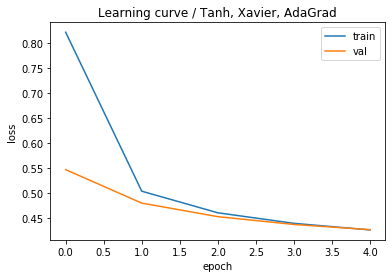

In [219]:
# Tanh
# Conv2D：フィルターサイズ２、パティング無し、ストライド１
# 最大プーリング：サイズ３、パディング無し、ストライド３

# エポック５
# 推定　→　Accuracy
y_pred = conv2d_1.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(conv2d_1.train_loss, label='train')
plt.plot(conv2d_1.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / Tanh, Xavier, AdaGrad')
plt.legend()
plt.show()

In [244]:
# 上記のプーリングを「平均プーリング」に変更してい処理

# Tanh
# Conv2D：フィルターサイズ２、パティング無し、ストライド１
# 平均プーリング：サイズ３、パディング無し、ストライド３


# 平均プーリングサイズ３、パディング無し、ストライド３）
pool_mean = Mean_pool(N_in = (conv1.NH_out, conv1.NW_out),
                                     Pool_size = (conv1.C_out, conv1.C_out, 3, 3),
                                     Strides = (3, 3),
                                     Padding = (0, 0))

# Layerリスト化
Layer_act2 = [conv1, act1, pool_mean, flat1, fc1, act2]

# 学習
conv2d_test = ScratchDeepNeuralNetrowkClassifier(Layer_act2, epoch_count=5)
conv2d_test.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習


正解率：0.8989166666666667


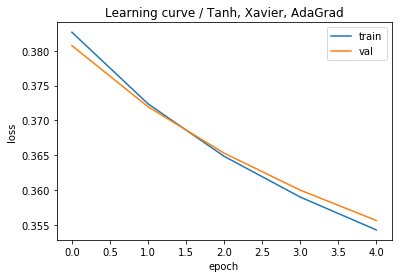

In [245]:
# 平均プーリングで処理

# Tanh
# Conv2D：フィルターサイズ２、パティング無し、ストライド１
# 平均プーリング：サイズ３、パディング無し、ストライド３

# エポック５
# 推定　→　Accuracy
y_pred = conv2d_test.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(conv2d_test.train_loss, label='train')
plt.plot(conv2d_test.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / Tanh, Xavier, AdaGrad')
plt.legend()
plt.show()

In [272]:
# ReLU
# Conv2D：フィルターサイズ３、パティング1、ストライド3
# 最大プーリング：サイズ２、パディング無し、ストライド２


# Input
Input = (20, 1, 28, 28)    # channel first : (N, C, NH, NW)

# Conv2D（フィルターサイズ３、パティング1、ストライド3）
conv3 = Conv2D(N_in=(Input[2], Input[3]),
                          Filter=(2, Input[1], 3, 3),
                          Strides=(3, 3),
                          Padding=(1, 1),
                          Initializer=He(Input[2]*Input[3]),
                          Optimizer=AdaGrad(0.01))
#活性化層
act3_1 = ReLU()
# 最大プーリング（サイズ２、パディング無し、ストライド２）
pool3 = Max_pool(N_in = (conv3.NH_out, conv3.NW_out),
                            Pool_size = (conv3.C_out, conv3.C_out, 2, 2),
                            Strides = (2, 2),
                            Padding = (0, 0))

# 平滑化
flat3 = Flatten()

# 全結合
# FC層へのnodes_in数を計算
FC_nodes_in = pool3.C_out*pool3.NH_out*pool3.NW_out
# 全結合インスタンス化
fc3 = FC(Nodes = (FC_nodes_in, y_train_one_hot.shape[1]),
              Initializer = He(FC_nodes_in),
              Optimizer = AdaGrad(0.01))
#活性化層
act3_2 = Softmax()

# Layerリスト化
Layer_act3 = [conv3, act3_1, pool3, flat3, fc3, act3_2]

# 学習
conv2d_3 = ScratchDeepNeuralNetrowkClassifier(Layer_act3, epoch_count=5)
conv2d_3.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習


正解率：0.7285833333333334


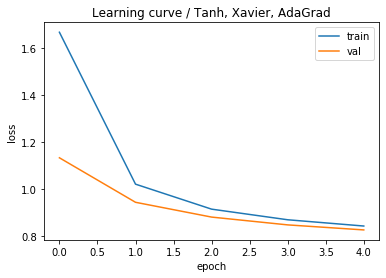

In [273]:
# ReLU
# Conv2D：フィルターサイズ３、パティング1、ストライド3
# 最大プーリング：サイズ２、パディング無し、ストライド２

# エポック５
# 推定　→　Accuracy
y_pred = conv2d_3.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(conv2d_3.train_loss, label='train')
plt.plot(conv2d_3.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / ReLU, He, AdaGrad')
plt.legend()
plt.show()

In [274]:
# ReLU
# Conv2D：フィルターサイズ３、パティング1、ストライド1
# 最大プーリング：サイズ２、パディング無し、ストライド２


# Input
Input = (20, 1, 28, 28)    # channel first : (N, C, NH, NW)

# Conv2D（フィルターサイズ３、パティング1、ストライド1）
conv4 = Conv2D(N_in=(Input[2], Input[3]),
                          Filter=(2, Input[1], 3, 3),
                          Strides=(1, 1),
                          Padding=(1, 1),
                          Initializer=He(Input[2]*Input[3]),
                          Optimizer=AdaGrad(0.01))
#活性化層
act4_1 = ReLU()
# 最大プーリング（サイズ２、パディング無し、ストライド２）
pool4 = Max_pool(N_in = (conv4.NH_out, conv4.NW_out),
                            Pool_size = (conv4.C_out, conv4.C_out, 2, 2),
                            Strides = (2, 2),
                            Padding = (0, 0))

# 平滑化
flat4 = Flatten()

# 全結合
# FC層へのnodes_in数を計算
FC_nodes_in = pool4.C_out*pool4.NH_out*pool4.NW_out
# 全結合インスタンス化
fc4 = FC(Nodes = (FC_nodes_in, y_train_one_hot.shape[1]),
              Initializer = He(FC_nodes_in),
              Optimizer = AdaGrad(0.01))
#活性化層
act4_2 = Softmax()

# Layerリスト化
Layer_act4 = [conv4, act4_1, pool4, flat4, fc4, act4_2]

# 学習
conv2d_4 = ScratchDeepNeuralNetrowkClassifier(Layer_act4, epoch_count=5)
conv2d_4.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習


正解率：0.9125


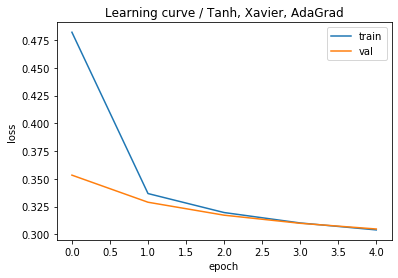

In [275]:
# ReLU
# Conv2D：フィルターサイズ３、パティング1、ストライド1
# 最大プーリング：サイズ２、パディング無し、ストライド２

# エポック５
# 推定　→　Accuracy
y_pred = conv2d_4.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(conv2d_4.train_loss, label='train')
plt.plot(conv2d_4.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / ReLU, He, AdaGrad')
plt.legend()
plt.show()

In [19]:
# ReLU
# Conv2D：フィルターサイズ２、パティング無し、ストライド１
# 最大プーリング：サイズ３、パディング無し、ストライド３


# Input
Input = (20, 1, 28, 28)    # channel first : (N, C, NH, NW)

# Conv2D（フィルターサイズ２、パティング無し、ストライド１）
conv5 = Conv2D(N_in=(Input[2], Input[3]),
                          Filter=(2, Input[1], 2, 2),
                          Strides=(1, 1),
                          Padding=(0, 0),
                          Initializer=He(Input[2]*Input[3]),
                          Optimizer=AdaGrad(0.01))
#活性化層
act5_1 = ReLU()
# 最大プーリング（サイズ３、パディング無し、ストライド３）
pool5 = Max_pool(N_in = (conv5.NH_out, conv5.NW_out),
                            Pool_size = (conv5.C_out, conv5.C_out, 3, 3),
                            Strides = (3, 3),
                            Padding = (0, 0))

# 平滑化
flat5 = Flatten()

# 全結合
# FC層へのnodes_in数を計算
FC_nodes_in = pool5.C_out*pool5.NH_out*pool5.NW_out
# 全結合インスタンス化
fc5 = FC(Nodes = (FC_nodes_in, y_train_one_hot.shape[1]),
              Initializer = He(FC_nodes_in),
              Optimizer = AdaGrad(0.01))
#活性化層
act5_2 = Softmax()

# Layerリスト化
Layer_act5 = [conv5, act5_1, pool5, flat5, fc5, act5_2]

# 学習
conv2d_5 = ScratchDeepNeuralNetrowkClassifier(Layer_act5, epoch_count=5)
conv2d_5.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

エポック1
2400回目の学習
エポック2
2400回目の学習
エポック3
2400回目の学習
エポック4
2400回目の学習
エポック5
2400回目の学習


正解率：0.88725


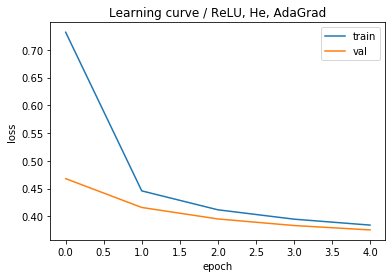

In [20]:
# ReLU
# Conv2D：フィルターサイズ２、パティング無し、ストライド１
# 最大プーリング：サイズ３、パディング無し、ストライド３

# エポック５
# 推定　→　Accuracy
y_pred = conv2d_5.predict(X_val)
print("正解率：{}".format(accuracy_score(y_val, y_pred)))
# 学習曲線
plt.plot(conv2d_5.train_loss, label='train')
plt.plot(conv2d_5.val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Learning curve / ReLU, He, AdaGrad')
plt.legend()
plt.show()

# 問題7】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。現在では実用的に使われることはありませんが、歴史的に重要なのは1998年の LeNet です。この構造を再現してMNISTに対して動かし、Accuracyを計算してください。

# 【問題8】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。


どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

# 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。


また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。


以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。

1.

* 入力サイズ : 144×144, 3チャンネル
* フィルタサイズ : 3×3, 6チャンネル
* ストライド : 1
* パディング : なし

2.

* 入力サイズ : 60×60, 24チャンネル
* フィルタサイズ : 3×3, 48チャンネル
* ストライド　: 1
* パディング : なし

3.

* 入力サイズ : 20×20, 10チャンネル
* フィルタサイズ: 3×3, 20チャンネル
* ストライド : 2
* パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

### 出力サイズ：(入力サイズ + 2✖︎パティングサイズ - フィルタサイズ)➗ストライドサイズ + 1
### パラメータ数：フィルタサイズ✖︎入力チャネル✖︎出力チャネル + 出力チャネル

In [6]:
# 1
# 出力サイズ
print("出力サイズ : ", (144 + 2*0 - 3)//1 + 1)
# パラメータ数
print("パラメータ数 : ", 3*3*3*6 + 6)

出力サイズ :  142
パラメータ数 :  168


In [9]:
# 2
# 出力サイズ
print("出力サイズ : ", (60 + 2*0 - 3)//1 + 1)
# パラメータ数
print("パラメータ数 : ", 3*3*24*48 + 48)

出力サイズ :  58
パラメータ数 :  10416


In [10]:
# 3
# 出力サイズ
print("出力サイズ : ", (20 + 2*0 - 3)//2 + 1)
# パラメータ数
print("パラメータ数 : ", 3*3*10*20 + 20)

出力サイズ :  9
パラメータ数 :  1820


# 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。

* 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由 

→フィルターはあるピクセルについて、周辺ピクセルとの関係性を調べるために用いられます。フィルターサイズが奇数の時は中心が定まるため、中心ピクセルと周辺ピクセルを分けられますが、フィルターサイズが偶数だと中心ピクセルが定まらなくなってしまいます。なのでフィルターサイズはいつも奇数。

* 高さや幅方向を持たない1×1のフィルタの効果

→次元削減(=モデルの高速化、軽量化）。また、出力にrelu等を与えることで非線形性UPができるから。